In [1]:
import torch
import numpy as np 
import json
import pickle
import cv2
import re
from pprint import pprint

from PIL import Image, ImageDraw

import os

print(torch.__version__,torch.cuda.is_available())

torch.cuda.empty_cache()
torch.cuda.device_count()

import detectron2
from detectron2.utils.logger import setup_logger
from detectron2.data.datasets import register_coco_instances, load_coco_json
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, default_argument_parser, \
                              default_setup, hooks, launch, DefaultTrainer, HookBase, default_writers
from detectron2.config import CfgNode as CN, get_cfg
from detectron2.modeling import build_model
import detectron2.utils.comm as comm
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.solver import build_lr_scheduler, build_optimizer
from detectron2.data import detection_utils as utils, build_detection_test_loader, DatasetMapper, \
                            build_detection_train_loader, MetadataCatalog, DatasetCatalog
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.checkpoint import DetectionCheckpointer, PeriodicCheckpointer
from detectron2.utils.events import EventStorage

logger = setup_logger()

import sys
sys.path.append("../")

from modules import CBMCOCOEvaluator, CustomMapper, add_cbm_config, add_uhcc_config, MyVisualizer

/mnt/srl-oahu-1/srl-hawaii-1/ariannab/anaconda3/envs/torch_detectron_ci/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.10.1 True


#### Model Evaluation 
Weights need to be downloaded from [here](https://drive.google.com/drive/folders/1VtDJ9Lma3GivCqnPrF-C7KFz2VAtsljk?usp=sharing) to load into the model. Code is written as if weights are in a weights/ directory at the highest level of the project structure. 

In [2]:
# register sample dataset in Detectron2 style 
# as per Detectron2, the first argument in load_coco_json has to be a fully-qualified path 
DatasetCatalog.register("sample", lambda: load_coco_json("/YOUR_FILE_PATH/sample_data/sample_data.json", "", "sample", ['region_shape', 'region_orientation', 'region_margin', 'region_echo', 'region_posterior', 'region_cancer']))

MetadataCatalog.get("sample").shape_classes = ['oval', 'not oval']
MetadataCatalog.get("sample").orientation_classes = ['parallel', 'not parallel']
MetadataCatalog.get("sample").margin_classes = ['circumscribed', 'not circumscribed']
MetadataCatalog.get("sample").echo_classes = ['anechoic', 'not anechoic']
MetadataCatalog.get("sample").posterior_classes = ['no features', 'features']
MetadataCatalog.get("sample").cancer_classes = ['benign', 'malignant']

MetadataCatalog.get("sample").thing_colors = ["g", "m"]
MetadataCatalog.get("sample").thing_classes = ['lesion']

[03/06 21:28:08 d2.data.datasets.coco]: Loaded 5 images in COCO format from /raid/srl/makawalu_2021-11-03/abunnell/CBM/github_repo_files/sample_data/sample_data.json
[03/06 21:28:08 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(800,), max_size=1333, sample_style='choice'), RandomFlip()]
[03/06 21:28:08 d2.data.common]: Serializing 5 elements to byte tensors and concatenating them all ...
[03/06 21:28:08 d2.data.common]: Serialized dataset takes 0.00 MiB
[03/06 21:28:08 d2.data.datasets.coco]: Loaded 5 images in COCO format from /raid/srl/makawalu_2021-11-03/abunnell/CBM/github_repo_files/sample_data/sample_data.json


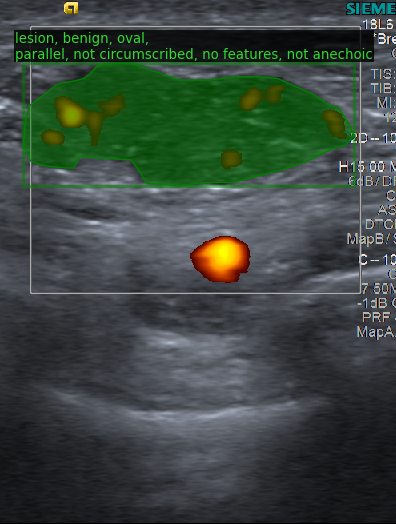

In [3]:
# visualize an image with its concept annotations
cfg = get_cfg()
cfg.MODEL.FIELDS = ['shape', 'orientation', 'margin', 'echo', 'posterior']
dataloader = build_detection_train_loader(DatasetCatalog.get("sample"), mapper=CustomMapper(cfg, True), total_batch_size = 1)

dataset_dict = DatasetCatalog.get("sample")

for i, d in enumerate(dataloader):
    org = next(item for item in dataset_dict if item["image_id"] == d[0]['image_id'])
    if (i < 1):
        img = cv2.cvtColor(cv2.imread(org["file_name"]), cv2.COLOR_BGR2RGB)
        visualizer = MyVisualizer(img[:, :, ::-1], metadata=MetadataCatalog.get("sample"), scale=0.8)
        out = visualizer.draw_dataset_dict(org)
        Image.fromarray(out.get_image()[:, :, ::-1]).show()
    else:
        break

#### Lesion-only Model Evaluation
**Stage 1** of training, the cancer head hasn't been attached to the Mask-RCNN backbone yet.  

In [4]:
cfg1 = get_cfg()
cfg1.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
add_uhcc_config(cfg1)
cfg1.merge_from_file("configs/stage_1.yaml")
cfg1.DATALOADER.NUM_WORKERS = 0
#reduce the number of detections for visualization purposes 
cfg1.TEST.DETECTIONS_PER_IMAGE = 1

model1 = build_model(cfg1)
DetectionCheckpointer(model1).load("weights/stage_1_weights.pth")

model1.eval()

GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequential(
        (0): BottleneckBlock

/mnt/srl-oahu-1/srl-hawaii-1/ariannab/anaconda3/envs/torch_detectron_ci/lib/python3.9/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/mnt/srl-oahu-1/srl-hawaii-1/ariannab/anaconda3/envs/torch_detectron_ci/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180487213/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


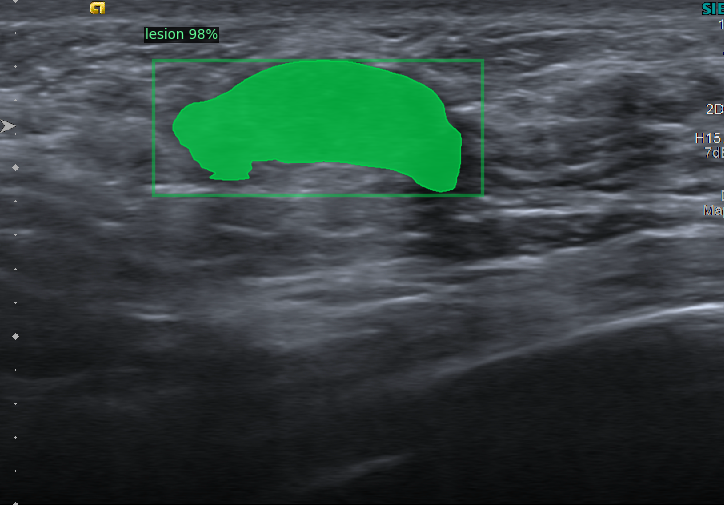

In [5]:
# visualize some predictions of the lesion-only model 
for i, d in enumerate(dataloader):
    if i < 1:
        pred = model1(d)
        visualizer2 = MyVisualizer(np.transpose(d[0]['image'].numpy(), (1, 2, 0)), 
                                            metadata=MetadataCatalog.get("sample"), 
                                            scale=0.8, show_lesion=True)
        if len(pred[0]['instances']) > 0:
            out2 = visualizer2.draw_instance_predictions(pred[0]['instances'])
            Image.fromarray(out2.get_image()[:, :, ::-1]).show()
    else: break

In [6]:
# evaluate the lesion-only model with the official COCO API
# create output_dir folder before running this, we need to specify this since our annotations aren't in standard COCO format (extra fields)
# APsmall and APmedium being -1/NaN is expected behavior
evaluator  =  COCOEvaluator("sample", output_dir='coco_results', max_dets_per_image=10, distributed=False, use_fast_impl=False)
val_loader =  build_detection_test_loader(DatasetCatalog.get("sample"), 
                                          mapper=DatasetMapper(cfg1, is_train=False, augmentations=[]))
output = inference_on_dataset(model1, val_loader, evaluator)

[03/06 19:56:05 d2.evaluation.coco_evaluation]: Trying to convert 'sample' to COCO format ...
WARNING [03/06 19:56:05 d2.data.datasets.coco]: Using previously cached COCO format annotations at 'coco_results/sample_coco_format.json'. You need to clear the cache file if your dataset has been modified.
[03/06 19:56:05 d2.data.datasets.coco]: Loaded 5 images in COCO format from /raid/srl/makawalu_2021-11-03/abunnell/CBM/github_repo_files/sample_data/sample_data.json
[03/06 19:56:05 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: []
[03/06 19:56:05 d2.data.common]: Serializing 5 elements to byte tensors and concatenating them all ...
[03/06 19:56:05 d2.data.common]: Serialized dataset takes 0.00 MiB
[03/06 19:56:05 d2.evaluation.evaluator]: Start inference on 5 batches
WARNING [03/06 19:56:05 d2.data.datasets.coco]: Using previously cached COCO format annotations at 'coco_results/sample_coco_format.json'. You need to clear the cache file if your dataset has been mo

#### Concept Model Evaluation
**Stage 2** of training, the cancer head has been attached, but it is cut off at the bottleneck. We're not including the cancer stage targets yet, only the 5 BI-RADS concepts

In [6]:
cfg2 = get_cfg()
cfg2.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
add_uhcc_config(cfg2)
add_cbm_config(cfg2)
cfg2.merge_from_file("configs/stage_2.yaml")
cfg2.DATALOADER.NUM_WORKERS = 0
#reduce the number of detections for visualization purposes 
cfg2.TEST.DETECTIONS_PER_IMAGE = 1

model2 = build_model(cfg2)
DetectionCheckpointer(model2).load("weights/stage_2_weights.pth")

model2.eval()

GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequential(
        (0): BottleneckBlock

[03/06 21:29:06 d2.data.datasets.coco]: Loaded 5 images in COCO format from /raid/srl/makawalu_2021-11-03/abunnell/CBM/github_repo_files/sample_data/sample_data.json
[03/06 21:29:06 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(800,), max_size=1333, sample_style='choice'), RandomFlip()]
[03/06 21:29:06 d2.data.common]: Serializing 5 elements to byte tensors and concatenating them all ...
[03/06 21:29:06 d2.data.common]: Serialized dataset takes 0.00 MiB
[03/06 21:29:06 d2.data.datasets.coco]: Loaded 5 images in COCO format from /raid/srl/makawalu_2021-11-03/abunnell/CBM/github_repo_files/sample_data/sample_data.json


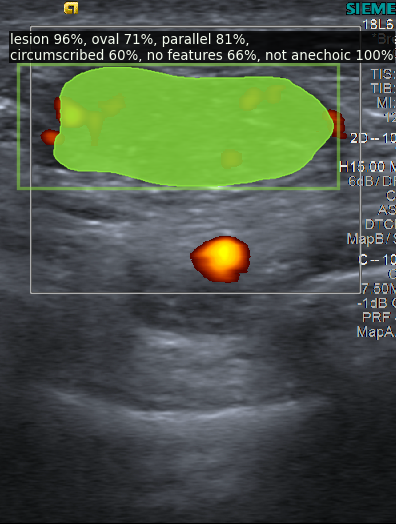

In [8]:
# visualize an image with its concept annotations
cfg = get_cfg()
cfg.MODEL.FIELDS = ['shape', 'orientation', 'margin', 'echo', 'posterior']
dataloader = build_detection_train_loader(DatasetCatalog.get("sample"), mapper=CustomMapper(cfg, True), total_batch_size = 1)

dataset_dict = DatasetCatalog.get("sample")

# visualize some predictions of the concept model 
for i, d in enumerate(dataloader):
    if i < 1:
        pred = model2(d)
        visualizer2 = MyVisualizer(np.transpose(d[0]['image'].numpy(), (1, 2, 0)), 
                                            metadata=MetadataCatalog.get("sample"), 
                                            scale=0.8, show_lesion=True)
        if len(pred[0]['instances']) > 0:
            out2 = visualizer2.draw_instance_predictions(pred[0]['instances'])
            Image.fromarray(out2.get_image()[:, :, ::-1]).show()
    else: break

**Sample data limitations:** Since only 5 sample images are provided, we can get some very strange results for the AUROC evaluation at the different IOU thresholds. AUROC can't be computed if not every GT class is represented in the subset (problem with region_cancer, region_orientation, region_echo, and region_posterior in the sample dataset). So, in order to *verify the functionality of the module only* the labels in sample_data_perturbed.json have been changed for image_2.png to make it so we have representation from every class. **These annotations do not represent what was annotated, please use sample_data.json for accurate annotations.**

In [9]:
# register sample dataset in Detectron2 style 
# as per Detectron2, the first argument in load_coco_json has to be a fully-qualified path 
DatasetCatalog.register("sample_perturbed", lambda: load_coco_json("/YOUR_FILE_PATH/sample_data/sample_data_perturbed.json", "", "sample_perturbed", ['region_shape', 'region_orientation', 'region_margin', 'region_echo', 'region_posterior', 'region_cancer']))

MetadataCatalog.get("sample_perturbed").shape_classes = ['oval', 'not oval']
MetadataCatalog.get("sample_perturbed").orientation_classes = ['parallel', 'not parallel']
MetadataCatalog.get("sample_perturbed").margin_classes = ['circumscribed', 'not circumscribed']
MetadataCatalog.get("sample_perturbed").echo_classes = ['anechoic', 'not anechoic']
MetadataCatalog.get("sample_perturbed").posterior_classes = ['no features', 'features']
MetadataCatalog.get("sample_perturbed").cancer_classes = ['benign', 'malignant']

MetadataCatalog.get("sample_perturbed").thing_colors = ["g", "m"]
MetadataCatalog.get("sample_perturbed").thing_classes = ['lesion']

In [10]:
# need to delete files in coco_results or allocate a new folder. Last time we didn't load in the concepts, so our files will be different and need to be re-written
evaluator  =  CBMCOCOEvaluator("sample_perturbed", concept_mapper={'posterior' : 'post', 'echo' : 'echo', 'shape' : 'shape', 'orientation' : 'orient', 'margin' : 'margin'}, 
                               output_dir='coco_results', 
                               distributed=False, max_dets_per_image=4)
val_loader =  build_detection_test_loader(DatasetCatalog.get("sample_perturbed"), 
                                          mapper=DatasetMapper(cfg2, is_train=False, augmentations=[]))
output = inference_on_dataset(model2, val_loader, evaluator)

[03/06 21:29:33 d2.evaluation.coco_evaluation]: Trying to convert 'sample_perturbed' to COCO format ...
[03/06 21:29:33 d2.data.datasets.coco]: Converting annotations of dataset 'sample_perturbed' to COCO format ...)
[03/06 21:29:33 d2.data.datasets.coco]: Loaded 5 images in COCO format from /raid/srl/makawalu_2021-11-03/abunnell/CBM/github_repo_files/sample_data/sample_data_perturbed.json
[03/06 21:29:33 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[03/06 21:29:33 d2.data.datasets.coco]: Conversion finished, #images: 5, #annotations: 5
[03/06 21:29:33 d2.data.datasets.coco]: Caching COCO format annotations at 'coco_results/sample_perturbed_coco_format.json' ...
[03/06 21:29:33 d2.data.datasets.coco]: Loaded 5 images in COCO format from /raid/srl/makawalu_2021-11-03/abunnell/CBM/github_repo_files/sample_data/sample_data_perturbed.json
[03/06 21:29:33 d2.data.datasets.coco]: Loaded 5 images in COCO format from /raid/srl/makawalu_2021-11-03/abunnell/CBM/github_repo_f

/mnt/srl-oahu-1/srl-hawaii-1/ariannab/anaconda3/envs/torch_detectron_ci/lib/python3.9/site-packages/confidenceinterval/delong.py:172: RuntimeWarning: Degrees of freedom <= 0 for slice
  sx = np.cov(v01)
/mnt/srl-oahu-1/srl-hawaii-1/ariannab/anaconda3/envs/torch_detectron_ci/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/mnt/srl-oahu-1/srl-hawaii-1/ariannab/anaconda3/envs/torch_detectron_ci/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/mnt/srl-oahu-1/srl-hawaii-1/ariannab/anaconda3/envs/torch_detectron_ci/lib/python3.9/site-packages/confidenceinterval/delong.py:173: RuntimeWarning: Degrees of freedom <= 0 for slice
  sy = np.cov(v10)


#### Cancer Model Evaluation
**Stages 3a, 3b, and 3c** of training, we're using the concepts to predict cancer status. Stage 3a refers to concepts only, 3b uses a side channel along with the concepts (with frozen concept weights from Stage 3a), and 3c is the linear cancer head from the concepts only. 

In [11]:
cfg3a = get_cfg()
cfg3a.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
add_uhcc_config(cfg3a)
add_cbm_config(cfg3a)
cfg3a.merge_from_file("configs/stage_3a.yaml")
cfg3a.DATALOADER.NUM_WORKERS = 0
#reduce the number of detections for visualization purposes 
cfg3a.TEST.DETECTIONS_PER_IMAGE = 1

model3a = build_model(cfg3a)
DetectionCheckpointer(model3a).load("weights/stage_3a_weights.pth")

model3a.eval()


cfg3b = get_cfg()
cfg3b.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
add_uhcc_config(cfg3b)
add_cbm_config(cfg3b)
cfg3b.merge_from_file("configs/stage_3b.yaml")
cfg3b.DATALOADER.NUM_WORKERS = 0
#reduce the number of detections for visualization purposes 
cfg3b.TEST.DETECTIONS_PER_IMAGE = 1

model3b = build_model(cfg3b)
DetectionCheckpointer(model3b).load("weights/stage_3b_weights.pth")

model3b.eval()


cfg3c = get_cfg()
cfg3c.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
add_uhcc_config(cfg3c)
add_cbm_config(cfg3c)
cfg3c.merge_from_file("configs/stage_3c.yaml")
cfg3c.DATALOADER.NUM_WORKERS = 0
#reduce the number of detections for visualization purposes 
cfg3c.TEST.DETECTIONS_PER_IMAGE = 1

model3c = build_model(cfg3c)
DetectionCheckpointer(model3c).load("weights/stage_3c_weights.pth")

model3c.eval()

GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequential(
        (0): BottleneckBlock

[03/06 21:30:06 d2.data.datasets.coco]: Loaded 5 images in COCO format from /raid/srl/makawalu_2021-11-03/abunnell/CBM/github_repo_files/sample_data/sample_data.json
[03/06 21:30:06 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(800,), max_size=1333, sample_style='choice'), RandomFlip()]
[03/06 21:30:06 d2.data.common]: Serializing 5 elements to byte tensors and concatenating them all ...
[03/06 21:30:06 d2.data.common]: Serialized dataset takes 0.00 MiB
[03/06 21:30:06 d2.data.datasets.coco]: Loaded 5 images in COCO format from /raid/srl/makawalu_2021-11-03/abunnell/CBM/github_repo_files/sample_data/sample_data.json


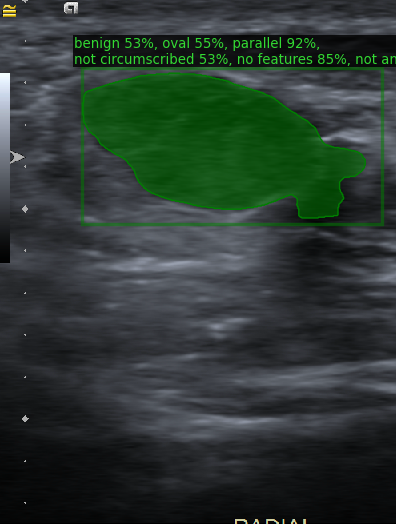

In [12]:
# visualize an image with its concept annotations
cfg = get_cfg()
cfg.MODEL.FIELDS = ['shape', 'orientation', 'margin', 'echo', 'posterior']
dataloader = build_detection_train_loader(DatasetCatalog.get("sample"), mapper=CustomMapper(cfg, True), total_batch_size = 1)

dataset_dict = DatasetCatalog.get("sample")

# visualize some predictions of the lesion-only model 
for i, d in enumerate(dataloader):
    if i < 1:
        pred = model3a(d)
        visualizer2 = MyVisualizer(np.transpose(d[0]['image'].numpy(), (1, 2, 0)), 
                                            metadata=MetadataCatalog.get("sample"), 
                                            scale=0.8, show_lesion=False)
        if len(pred[0]['instances']) > 0:
            out2 = visualizer2.draw_instance_predictions(pred[0]['instances'])
            Image.fromarray(out2.get_image()[:, :, ::-1]).show()
    else: break

In [7]:
evaluator  =  CBMCOCOEvaluator("sample_perturbed", concept_mapper={'cancer' : 'cancer'}, 
                               output_dir='coco_results', 
                               distributed=False, max_dets_per_image=4)
test_loader =  build_detection_test_loader(DatasetCatalog.get("sample_perturbed"), 
                                          mapper=DatasetMapper(cfg3a, is_train=False, augmentations=[]))

output_test_3a = inference_on_dataset(model3a, test_loader, evaluator)
print('*'*30)
output_test_3b = inference_on_dataset(model3b, test_loader, evaluator)
print('*'*30)
output_test_3c = inference_on_dataset(model3c, test_loader, evaluator)

[03/06 21:21:28 d2.evaluation.coco_evaluation]: Trying to convert 'sample_perturbed' to COCO format ...
WARNING [03/06 21:21:28 d2.data.datasets.coco]: Using previously cached COCO format annotations at 'coco_results/sample_perturbed_coco_format.json'. You need to clear the cache file if your dataset has been modified.
[03/06 21:21:28 d2.data.datasets.coco]: Loaded 5 images in COCO format from /raid/srl/makawalu_2021-11-03/abunnell/CBM/github_repo_files/sample_data/sample_data_perturbed.json
[03/06 21:21:28 d2.data.datasets.coco]: Loaded 5 images in COCO format from /raid/srl/makawalu_2021-11-03/abunnell/CBM/github_repo_files/sample_data/sample_data_perturbed.json
[03/06 21:21:28 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: []
[03/06 21:21:28 d2.data.common]: Serializing 5 elements to byte tensors and concatenating them all ...
[03/06 21:21:28 d2.data.common]: Serialized dataset takes 0.00 MiB
[03/06 21:21:28 d2.evaluation.evaluator]: Start inference on 5 b

/mnt/srl-oahu-1/srl-hawaii-1/ariannab/anaconda3/envs/torch_detectron_ci/lib/python3.9/site-packages/confidenceinterval/delong.py:172: RuntimeWarning: Degrees of freedom <= 0 for slice
  sx = np.cov(v01)
/mnt/srl-oahu-1/srl-hawaii-1/ariannab/anaconda3/envs/torch_detectron_ci/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/mnt/srl-oahu-1/srl-hawaii-1/ariannab/anaconda3/envs/torch_detectron_ci/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/mnt/srl-oahu-1/srl-hawaii-1/ariannab/anaconda3/envs/torch_detectron_ci/lib/python3.9/site-packages/confidenceinterval/delong.py:173: RuntimeWarning: Degrees of freedom <= 0 for slice
  sy = np.cov(v10)


[03/06 21:21:29 d2.evaluation.evaluator]: Total inference time: 0:00:00.060540 (0.060540 s / iter per device, on 1 devices)
[03/06 21:21:29 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00 (0.057499 s / iter per device, on 1 devices)
[03/06 21:21:29 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[03/06 21:21:29 d2.evaluation.coco_evaluation]: Saving results to coco_results/coco_instances_results.json
[03/06 21:21:29 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
[03/06 21:21:29 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00 (0.057499 s / iter per device, on 1 devices)
[03/06 21:21:29 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[03/06 21:21:29 d2.evaluation.coco_evaluation]: Saving results to coco_results/coco_instances_results.json
[03/06 21:21:29 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DON

#### Concept Intervention 
For model evaluation with all corrected concepts, we can use hooks in PyTorch to amend all the incorrect concepts. 

In [8]:
side_features = dict()
def getSideChannelActivation(name=None):
    # the hook signature
    def hook(model, input, output):
        side_features['pred_side'] = output.detach().cpu()
    return hook

concept_features = dict()
def getConceptActivation(name=None):
    # the hook signature
    def hook(model, input, output):
        concept_features['pred_concepts'] = output.detach().cpu()
    return hook

h = model3b.roi_heads.cancer_head.transfer_concepts[2].register_forward_hook(getConceptActivation('concept_activation'))
h2 = model3b.roi_heads.cancer_head.transfer_side[2].register_forward_hook(getSideChannelActivation('side_activation'))

In [12]:
# running everything through the concepts-only model so we can adjust whatever needs to be adjusted
CORRECTION_FACTOR = "maximal" # can be one of "minimal", "maximal", or "reciprocal"

def cancer_only_execution(adj_concept_logits, model, instances):
    # pass the adjusted logits through the cancer-only model which we've got loaded in 
    cancer_pred_logits = model.roi_heads.cancer_head.second_model(adj_concept_logits).detach()
    output = model.roi_heads.cancer_head.inference(adj_concept_logits, cancer_pred_logits, ("shape", "margin", "orientation", "echo", "posterior"), [instances[0]['instances']])
    output[0].set('pred_boxes', detectron2.structures.Boxes(output[0].get('pred_boxes').tensor.detach()))
    instances[0]['instances'] = output[0]
    return instances

def adj_single_gt_annotation(pred, org):
    device = pred[0]['instances'].shape_pred.device
    # fill our resulting array with dummy values
    adj_concepts = (torch.ones_like(concept_features['pred_concepts'])*-1).to(device)
    # if we only have one ground truth anno, then we can match up all proposed 
    # lesions with that! 
    if CORRECTION_FACTOR == "minimal":
        fixing_0s = torch.Tensor([-0.05]).to(torch.float32).to(device)
        fixing_1s = torch.Tensor([0.05]).to(torch.float32).to(device)
    elif CORRECTION_FACTOR == "maximal":
        fixing_0s = torch.Tensor([-4.625]).to(torch.float32).to(device)
        fixing_1s = torch.Tensor([4.625]).to(torch.float32).to(device)

    for i, concept in enumerate(["shape", "margin", "orientation", "echo", "posterior"]):
        if concept == 'orientation': concept_name = 'orient'
        elif concept == 'posterior': concept_name = 'post'
        else: concept_name = concept
        # get truth value for each of them 
        a_tensor = torch.tensor(org['annotations'][0]['region_' + concept], device=device)
        # Broadcast 'a_tensor' to match the shape of pred[0]['instances'].shape_pred
        a_broadcasted = a_tensor.unsqueeze(0).expand_as(pred[0]['instances'].get(concept_name + '_pred')).to(torch.float32)

        # where we predicted the class right, fill in the logit values from our hook. 
        # where we predicted the class wrong, fill in the ground truth class 
        intermediate = torch.where(pred[0]['instances'].get(concept_name + '_pred') == a_broadcasted, concept_features['pred_concepts'][:, i].to(device), a_broadcasted)

        if CORRECTION_FACTOR == 'reciprocal':
            final_corrected = torch.where(intermediate == 1.0, -1*concept_features['pred_concepts'][:, i].to(device), intermediate)
            final_corrected = torch.where(final_corrected == 0.0, -1*concept_features['pred_concepts'][:, i].to(device), final_corrected)
        else:
            # if we predicted wrong, but the truth is class 1 
            correcting_true_1s = torch.where(intermediate == 1.0, fixing_1s, intermediate)
            # if we predicted wrong, but the truth is class 0 
            final_corrected = torch.where(correcting_true_1s == 0.0, fixing_0s, correcting_true_1s)

        adj_concepts[:, i] = final_corrected

    if SIDE_CHANNEL:
        adj_concepts = torch.cat((adj_concepts, side_features['pred_side'].to('cuda')), dim=1)

    return adj_concepts 

def adj_annotation_one_of_many(matched_instance, matched_annotation, idx):
    device = matched_instance.shape_pred.device
    # fill our resulting array with dummy values
    adj_concepts = (torch.ones((1, concept_features['pred_concepts'].shape[1]))*-1).to(device)
    # if we only have one ground truth anno, then we can match up all proposed 
    # lesions with that! 
    if CORRECTION_FACTOR == "minimal":
        fixing_0s = torch.Tensor([-0.05]).to(torch.float32).to(device)
        fixing_1s = torch.Tensor([0.05]).to(torch.float32).to(device)
    elif CORRECTION_FACTOR == "maximal":
        fixing_0s = torch.Tensor([-3.419]).to(torch.float32).to(device)
        fixing_1s = torch.Tensor([11.922]).to(torch.float32).to(device)

    for i, concept in enumerate(["shape", "margin", "orientation", "echo", "posterior"]):
        if concept == 'orientation': concept_name = 'orient'
        elif concept == 'posterior': concept_name = 'post'
        else: concept_name = concept
        if matched_annotation['region_' + concept] == matched_instance.get(concept_name + '_pred'):
            # if we predicted correctly for this concept, then fill in the originally-computed logit
            adj_concepts[:, i] = concept_features['pred_concepts'][idx, i].to(device)
        # if we predicted class 0, when the truth was class 1
        elif matched_annotation['region_' + concept] > matched_instance.get(concept_name + '_pred'):
            if CORRECTION_FACTOR == 'reciprocal':
                adj_concepts[:, i] = -1*concept_features['pred_concepts'][idx, i].to(device)
            else:
                adj_concepts[:, i] = fixing_1s
        # if we predicted class 1, when the truth was class 0
        elif matched_annotation['region_' + concept] < matched_instance.get(concept_name + '_pred'):
            if CORRECTION_FACTOR == 'reciprocal':
                adj_concepts[:, i] = -1*concept_features['pred_concepts'][idx, i].to(device)
            else:
                adj_concepts[:, i] = fixing_0s

    return adj_concepts

def fix_multiple_gt_annotations(pred, org):
    adj_concepts = (torch.ones_like(concept_features['pred_concepts'])*-1).to('cuda')
    boxes = []
    for x in org['annotations']:
        boxes.append([x['bbox'][0], x['bbox'][1], x['bbox'][0]+x['bbox'][2], x['bbox'][1]+x['bbox'][3]])

    boxes = detectron2.structures.Boxes(boxes).to('cuda')
    # calculate iou between predicted and ground truth boxes
    ious = detectron2.structures.pairwise_iou(pred[0]['instances'].get('pred_boxes'), boxes)
    # if we line up with a gt annotation, indicate which one. If not, fill in a -1
    matched = torch.where(torch.amax(ious, dim=1) > 0, torch.argmax(ious, dim=1), -1)
    for i, x in enumerate(matched):
        if x > -1:
            predicted = pred[0]['instances'][i]
            matched_gt = org['annotations'][int(x)]
            adj_concepts[i, :] = adj_annotation_one_of_many(predicted, matched_gt, i)
        else:
            adj_concepts[i, :] = concept_features['pred_concepts'][i, :]

    if SIDE_CHANNEL:
        adj_concepts = torch.cat((adj_concepts, side_features['pred_side'].to('cuda')), dim=1)
    return adj_concepts
            

In [13]:
val_loader =  build_detection_test_loader(DatasetCatalog.get("sample"), 
                                          mapper=DatasetMapper(cfg3b, is_train=False, augmentations=[]))

dataset_dict = DatasetCatalog.get("sample")

SIDE_CHANNEL = True

def get_all_inputs_outputs():
  for data in val_loader:
    pred = model3b(data)
    org = next(item for item in dataset_dict if item["image_id"] == data[0]['image_id'])
    # if we predicted any objects 
    if len(pred[0]['instances']) > 0:
        # if the ground truth has only one annotation, we match everything to that 
        if len(org['annotations']) == 1:
            correct_concept_logits = adj_single_gt_annotation(pred, org)
            output = cancer_only_execution(correct_concept_logits, model3b, pred)
            yield data, output
        # if the ground truth has no annotations, then we leave concepts as is 
        elif len(org['annotations']) < 1:
            if SIDE_CHANNEL:
                correct_concept_logits = torch.cat((concept_features['pred_concepts'].to('cuda'), side_features['pred_side'].to('cuda')), dim=1)
            else:
                correct_concept_logits = concept_features['pred_concepts'].to('cuda')
        elif len(org['annotations']) > 1:
            correct_concept_logits = fix_multiple_gt_annotations(pred, org)
            output = cancer_only_execution(correct_concept_logits, model3b, pred)
            yield data, output
    else:
        yield data, pred

[03/06 21:26:21 d2.data.datasets.coco]: Loaded 5 images in COCO format from /raid/srl/makawalu_2021-11-03/abunnell/CBM/github_repo_files/sample_data/sample_data.json
[03/06 21:26:21 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: []
[03/06 21:26:21 d2.data.common]: Serializing 5 elements to byte tensors and concatenating them all ...
[03/06 21:26:21 d2.data.common]: Serialized dataset takes 0.00 MiB
[03/06 21:26:21 d2.data.datasets.coco]: Loaded 5 images in COCO format from /raid/srl/makawalu_2021-11-03/abunnell/CBM/github_repo_files/sample_data/sample_data.json
[03/06 21:26:21 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: []
[03/06 21:26:21 d2.data.common]: Serializing 5 elements to byte tensors and concatenating them all ...
[03/06 21:26:21 d2.data.common]: Serialized dataset takes 0.00 MiB
[03/06 21:26:21 d2.data.datasets.coco]: Loaded 5 images in COCO format from /raid/srl/makawalu_2021-11-03/abunnell/CBM/github_repo_files/sampl

In [15]:
evaluator  =  CBMCOCOEvaluator("sample_perturbed", concept_mapper={'cancer' : 'cancer'}, 
                               output_dir='coco_results', 
                               distributed=False, max_dets_per_image=4)

evaluator.reset()
for inputs, outputs in get_all_inputs_outputs():
  evaluator.process(inputs, outputs)
  
eval_results = evaluator.evaluate()

[03/06 21:26:43 d2.data.datasets.coco]: Loaded 5 images in COCO format from /raid/srl/makawalu_2021-11-03/abunnell/CBM/github_repo_files/sample_data/sample_data_perturbed.json
[03/06 21:26:43 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[03/06 21:26:43 d2.evaluation.coco_evaluation]: Saving results to coco_results/coco_instances_results.json
[03/06 21:26:43 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.485
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 10 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 10 ] = 0.505
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets= 10 ] = -1.000
 

/mnt/srl-oahu-1/srl-hawaii-1/ariannab/anaconda3/envs/torch_detectron_ci/lib/python3.9/site-packages/confidenceinterval/delong.py:172: RuntimeWarning: Degrees of freedom <= 0 for slice
  sx = np.cov(v01)
/mnt/srl-oahu-1/srl-hawaii-1/ariannab/anaconda3/envs/torch_detectron_ci/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/mnt/srl-oahu-1/srl-hawaii-1/ariannab/anaconda3/envs/torch_detectron_ci/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/mnt/srl-oahu-1/srl-hawaii-1/ariannab/anaconda3/envs/torch_detectron_ci/lib/python3.9/site-packages/confidenceinterval/delong.py:173: RuntimeWarning: Degrees of freedom <= 0 for slice
  sy = np.cov(v10)
